<h1>HW2 - Convolutional Neural Networks- Practical Q1_Part A</h1>
<h3><font color=yellow>Total Points: 100</font></h3>



<font color=greeen>Please, name this file as HW2_Q1_{Student_ID}.ipynb</font>

<h2>Full Name: Mahdi Salahshour</h2>
<h2>Student ID: 99101727</h2>

#Imports

In [17]:
import os
from torch.utils.data import Subset
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

#Preparing Data

In [18]:
%%capture
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
from torchvision import datasets
#defining the transforms we need (converting images to tensor and normalizing)
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

## Download FashionMNIST dataset
train_set = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
test_set = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)


In [19]:
# Using GPU if it's available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# split training set into train and validation data
torch.manual_seed(0)

total_size = len(train_set)
train_size = int(0.75 * total_size)
val_size = total_size - train_size
indices = list(range(total_size))
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_ds = Subset(train_set, train_indices)
val_ds = Subset(train_set, val_indices)



In [20]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# Loading the dataset into memory using Dataloader
# use your desired batch size and shuffle is necessary

train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
val_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

classes = train_set.classes



#Visualizing a few data samples

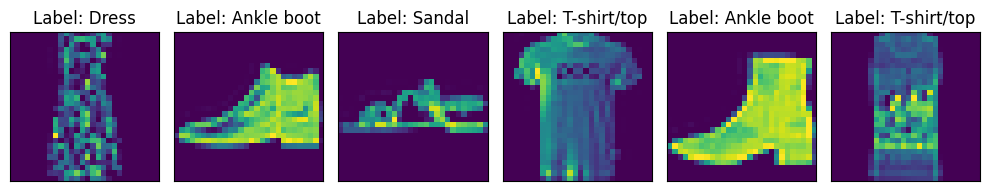

In [21]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,6),axes.flat):
    img,label=images[i],labels[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Label: {classes[label]}")

plt.tight_layout()
plt.show()

#Building Model Arcitechture

<h2>Implement the Convolutional Neural Network shown below:</h2>

<img src='https://drive.google.com/uc?id=1eN-rEyMCmApg7tASsmtkBQM7HbU1ZORH'>

In [31]:
class Simple_CNN(nn.Module):
  def __init__(self):
    super(Simple_CNN, self).__init__()
    self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fc1 = nn.Linear(2304, 600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(600, 120)
    self.fc3 = nn.Linear(120, 10)


  def forward(self, x):
    #################################################################################
    #                          COMPLETE THE FOLLOWING SECTION                       #
    #################################################################################
    """ Implement the forward propagation steps """
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out


  def Fit(self, num_epochs, train_loader, val_loader, optimizer, criterion):
    train_losses = []
    val_losses = []
    train_accuracies=[]
    val_accuracies=[]

    for epoch in range(num_epochs):
      train_per_epoch_loss=0
      train_data_total = 0
      train_data_correct = 0

      ####### Training Phase ########
      self.train()
      with tqdm(train_loader, unit="batch") as batches:
        epoch_loss = 0
        for images, labels in batches:
          batches.set_description(f"Epoch {epoch + 1}")
          #################################################################################
          #                          COMPLETE THE FOLLOWING SECTION                       #
          #################################################################################
          """ Implement training steps """
          optimizer.zero_grad()
          images = images.to(device)
          labels= labels.to(device)
          output_vals = self(images)
          calculated_loss = criterion(output_vals, labels)
          calculated_loss.backward()
          optimizer.step()

          _, predicted_values = torch.max(output_vals.data, 1)
          train_data_correct += (predicted_values == labels).sum().item()
          train_data_total += labels.size(0)
          train_per_epoch_loss += calculated_loss.item()

          batches.set_postfix(train_loss = (train_per_epoch_loss/len(train_loader)), train_accuracy = (train_data_correct * 100 / train_data_total)) # show loss and accuracy per batch of data


      train_accuracy = train_data_correct * 100 / train_data_total
      train_accuracies.append(train_accuracy)
      train_losses.append(train_per_epoch_loss/len(train_loader))


      ####### Validation Phase ########
      val_per_epoch_loss=0
      val_data_total = 0
      val_data_correct = 0

      self.eval()
      with torch.no_grad():
        for images, labels in val_loader:
          #################################################################################
          #                          COMPLETE THE FOLLOWING SECTION                       #
          #################################################################################
              images = images.to(device)
              labels = labels.to(device)
              """ Implement Validation steps """
              outputs = self(images)
              loss = criterion(outputs, labels)

              _, predictions = torch.max(outputs.data, 1)
              val_data_correct += (predictions == labels).sum().item()
              val_data_total += labels.size(0)
              val_per_epoch_loss += loss.item()



      val_accuracy = val_data_correct * 100 / val_data_total
      val_losses.append(val_per_epoch_loss/len(val_loader))
      val_accuracies.append(val_accuracy)

      print(f"End of Epoch {epoch + 1}: Validation accuray: {val_accuracy}, Validation Loss: {val_per_epoch_loss/len(val_loader)}")
      print("-"*40)

    self.history={
      'train_losses':train_losses,
      'val_losses':val_losses,
      'train_accuracies':train_accuracies,
      'val_accuracies':val_accuracies
    }
    return self.history


In [32]:
model = Simple_CNN()
model.to(device)
print(model)

Simple_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


#Training the model

In [33]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
num_epochs = 10
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


history=model.Fit(num_epochs, train_dataloader, val_dataloader, optimizer, criterion)

Epoch 1: 100%|██████████| 938/938 [00:26<00:00, 35.99batch/s, train_accuracy=85, train_loss=0.424]


End of Epoch 1: Validation accuray: 87.87833333333333, Validation Loss: 0.3349445935235476
----------------------------------------


Epoch 2: 100%|██████████| 938/938 [00:26<00:00, 36.02batch/s, train_accuracy=89.3, train_loss=0.299]


End of Epoch 2: Validation accuray: 91.31166666666667, Validation Loss: 0.24197440470523163
----------------------------------------


Epoch 3: 100%|██████████| 938/938 [00:26<00:00, 35.26batch/s, train_accuracy=90.9, train_loss=0.257]


End of Epoch 3: Validation accuray: 91.33, Validation Loss: 0.2488201038657761
----------------------------------------


Epoch 4: 100%|██████████| 938/938 [00:26<00:00, 35.79batch/s, train_accuracy=91.7, train_loss=0.232]


End of Epoch 4: Validation accuray: 91.24, Validation Loss: 0.23400462017670623
----------------------------------------


Epoch 5: 100%|██████████| 938/938 [00:26<00:00, 35.91batch/s, train_accuracy=92.6, train_loss=0.207]


End of Epoch 5: Validation accuray: 93.51, Validation Loss: 0.1768481541675196
----------------------------------------


Epoch 6: 100%|██████████| 938/938 [00:26<00:00, 35.83batch/s, train_accuracy=93, train_loss=0.193]


End of Epoch 6: Validation accuray: 94.24833333333333, Validation Loss: 0.161568941278403
----------------------------------------


Epoch 7: 100%|██████████| 938/938 [00:30<00:00, 30.91batch/s, train_accuracy=93.4, train_loss=0.181]


End of Epoch 7: Validation accuray: 95.05166666666666, Validation Loss: 0.13949459849167734
----------------------------------------


Epoch 8: 100%|██████████| 938/938 [00:26<00:00, 35.72batch/s, train_accuracy=94, train_loss=0.165]


End of Epoch 8: Validation accuray: 95.195, Validation Loss: 0.13285037192470356
----------------------------------------


Epoch 9: 100%|██████████| 938/938 [00:26<00:00, 35.28batch/s, train_accuracy=94.4, train_loss=0.154]


End of Epoch 9: Validation accuray: 95.25, Validation Loss: 0.13010862266926815
----------------------------------------


Epoch 10: 100%|██████████| 938/938 [00:25<00:00, 36.28batch/s, train_accuracy=94.6, train_loss=0.145]


End of Epoch 10: Validation accuray: 96.02, Validation Loss: 0.11106394387896794
----------------------------------------


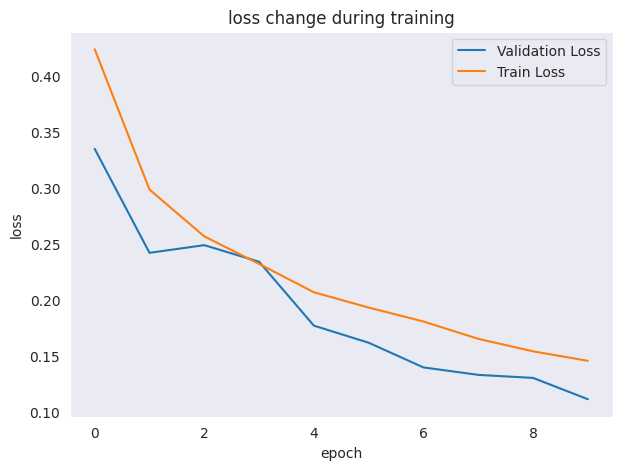

In [34]:
# plot losses
plt.subplots(figsize=(7, 5))
sns.set_style("dark")
sns.lineplot(data=history['val_losses'],label="Validation Loss")
sns.lineplot(data=np.asarray(history['train_losses']),label="Train Loss").set(title="loss change during training", xlabel="epoch", ylabel="loss")
plt.legend()
plt.show()

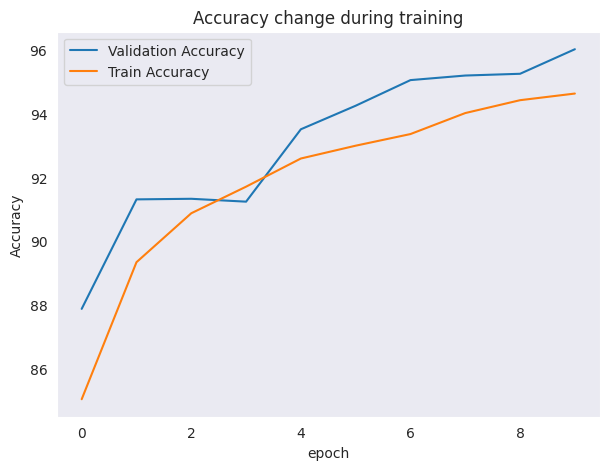

In [35]:
# plot Accuracy
plt.subplots(figsize=(7, 5))
sns.set_style("dark")
sns.lineplot(data=history['val_accuracies'],label="Validation Accuracy")
sns.lineplot(data=np.asarray(history['train_accuracies']),label="Train Accuracy").set(title="Accuracy change during training", xlabel="epoch", ylabel="Accuracy")
plt.legend()
plt.show()

# Prediction on Test Data

In [36]:
def predict(images, model):
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
  #Your Code Here

    images = images.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

    return predicted

**Accuracy Result on Test Data**

In [37]:
correct = 0
total = 0
y_pred_list = []
y_true_list = []
with torch.no_grad():
  for data in test_dataloader:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
    inputs = data[0].to(device)
    labels = data[1].to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    for  x in predicted.cpu().numpy(): y_pred_list.append(x)
    for  x in labels.cpu().numpy(): y_true_list.append(x)

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 91 %


**Classification report**

In [38]:
print(classification_report(y_true_list, y_pred_list, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.88      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.82      0.91      0.86      1000
       Dress       0.92      0.91      0.91      1000
        Coat       0.88      0.86      0.87      1000
      Sandal       0.98      0.97      0.98      1000
       Shirt       0.79      0.72      0.75      1000
     Sneaker       0.91      0.99      0.95      1000
         Bag       0.99      0.98      0.99      1000
  Ankle boot       0.99      0.92      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



<Axes: >

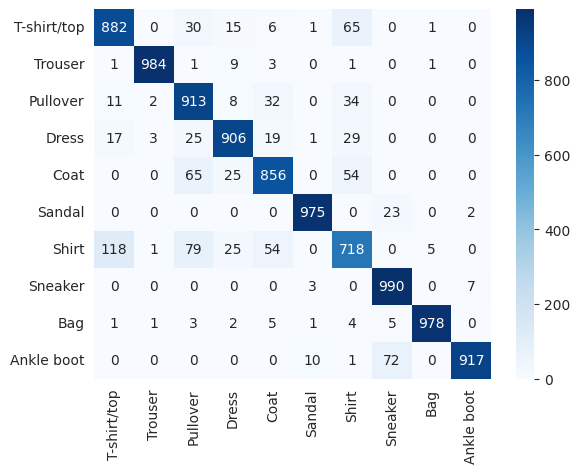

In [39]:
cf_matrix = confusion_matrix(y_true_list, y_pred_list)
sns.heatmap(cf_matrix, xticklabels=classes, yticklabels=classes, annot=True, cmap='Blues', fmt='g')

**Displaying a random set of images from test data**

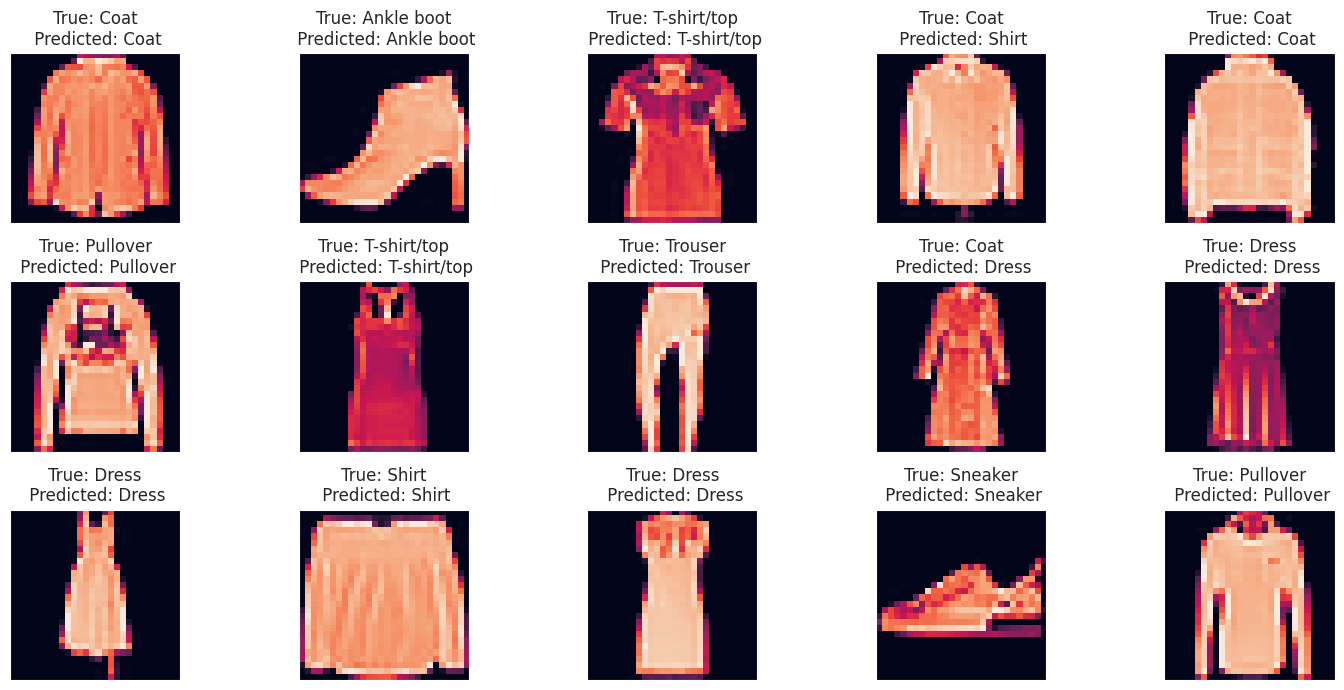

In [40]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
predicted=predict(images, model)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,16),axes.flat):
    img,label=images[i],labels[i]
    pred=predicted[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"True: {classes[label]}\n Predicted: {classes[pred]}")

plt.tight_layout()
plt.show()